In [84]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = "PATH_TO_STORED_DATASET"

In [426]:
# Read dataset
final_df = pd.read_csv(f"{path}final_df_all.csv")
# final_df

### Data visualization

In [4]:
def plot_evolution_occupancy(df):
    
    plt.figure(figsize=(27, 4))
    df = df.copy()
    df['date'] = pd.to_datetime(df['date']) # convert date to datetime
    
    # Plot lines
    plt.plot(df['date'], df['occupancy'], color='gray', linestyle='-')
    # Plot markers
    # plt.scatter(df['date'], df['occupancy'], c=df['day_type'], cmap='viridis', marker='o')
    for day_type in df['day_type'].unique():
        subset = df[df['day_type'] == day_type]
        plt.scatter(subset['date'], subset['occupancy'], marker='o', label=f'Day Type {day_type}')
    
    plt.xlabel('Date')
    plt.ylabel('Occupancy')
    
    # Set the x-axis major locator to show month and year
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

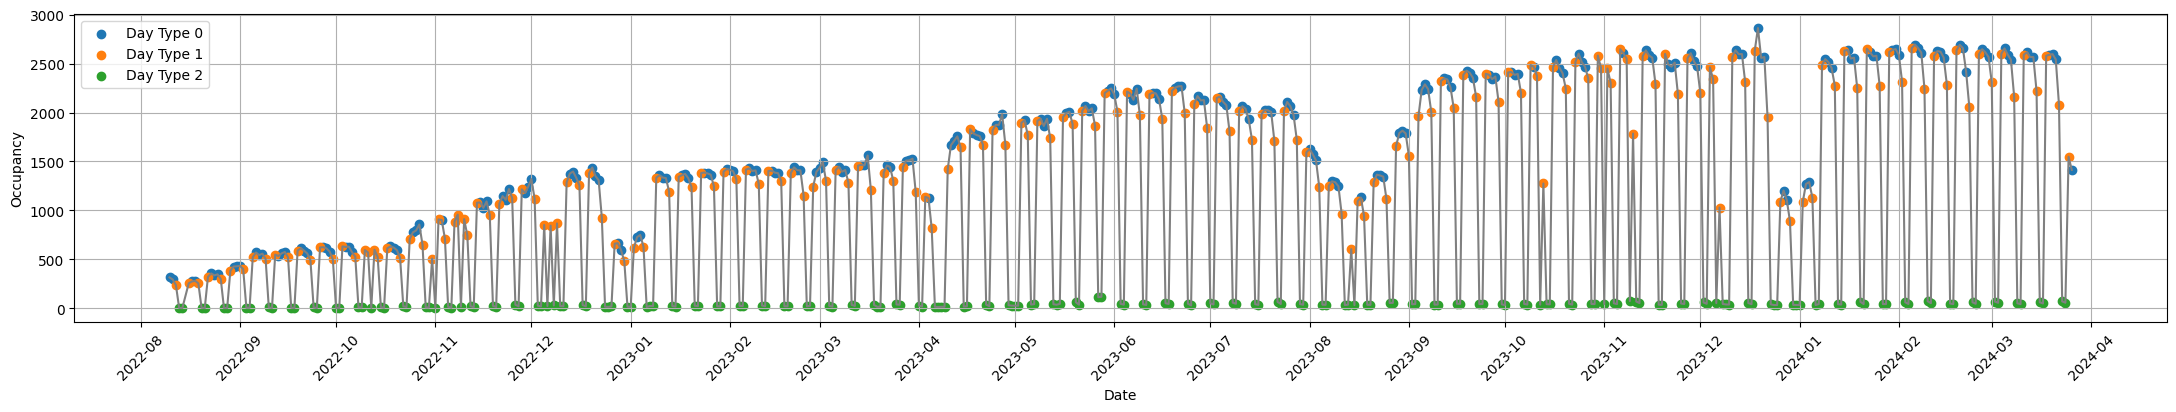

In [5]:
plot_evolution_occupancy(final_df)

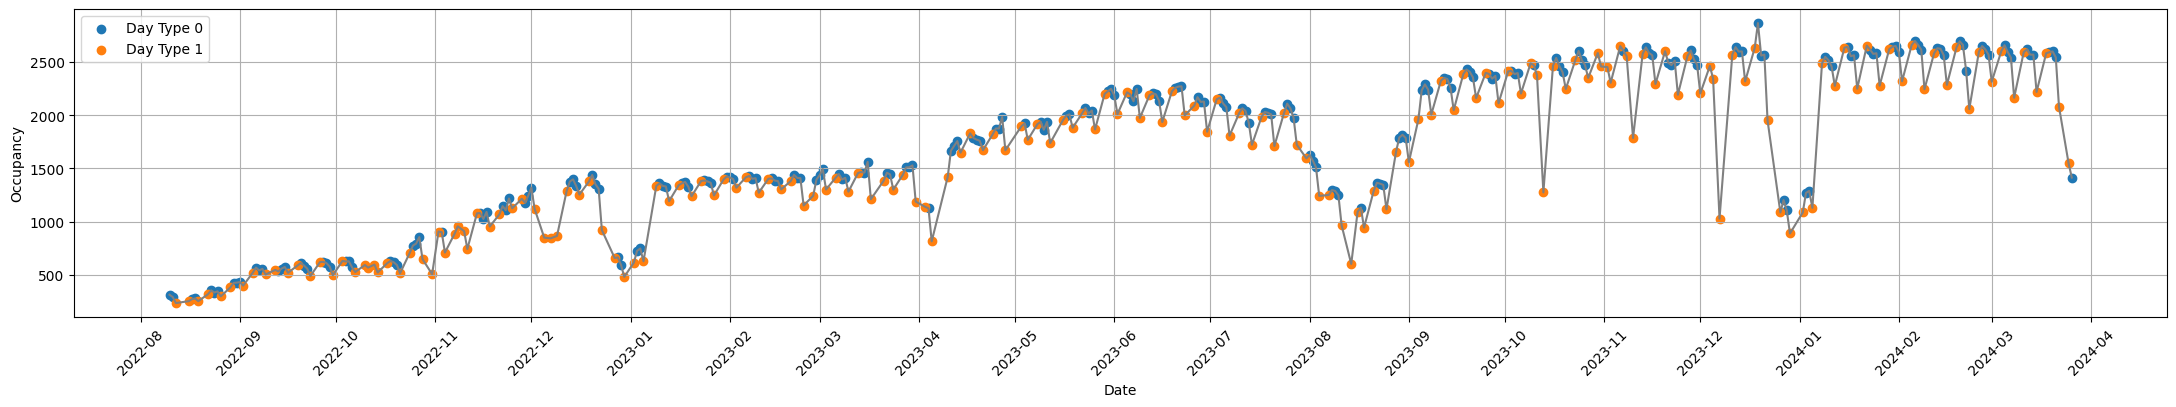

In [7]:
week_df = final_df.loc[final_df['day_type'] != 2]
plot_evolution_occupancy(week_df)

### Exploratory Data Analysis

In [4]:
df = final_df[['occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week','day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
# occupancy_df = occupancy_df[(occupancy_df['date']>= "2023-03-01") & (occupancy_df['date']< "2024-03-01")] # Sep 22 - Feb 24 (año y medio)
df = df.drop(columns=['date'])
df = df.reset_index(drop=True)

In [16]:
# Summary statistics
# df = final_df
df.describe()

,occupancy,reserv_workplace,capacity,year,month,day_month,day_week,day_type,weather_code,temperature_2m_max,temperature_2m_min,precipitation_sum
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,1140.350168,897.269360,2882.505051,2022.904040,6.732323,15.787879,4.005051,0.949495,21.175084,20.067331,9.536803,1.683502
std,964.233318,790.173833,783.945767,0.613961,3.743559,8.731258,1.999572,0.831996,26.669288,8.715161,6.979329,5.158032
min,2.000000,0.000000,843.000000,2022.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.126000,-4.424000,0.000000
25%,44.000000,0.000000,2323.000000,2023.000000,3.000000,8.000000,2.000000,0.000000,3.000000,12.426000,3.488500,0.000000
50%,1207.000000,864.500000,3374.000000,2023.000000,7.000000,16.000000,4.000000,1.000000,3.000000,19.001000,8.476000,0.000000
75%,2064.000000,1611.500000,3439.000000,2023.000000,10.000000,23.000000,6.000000,2.000000,51.000000,27.063498,15.126000,0.600000
max,2863.000000,2264.000000,3830.000000,2024.000000,12.000000,31.000000,7.000000,2.000000,96.000000,40.376000,25.226000,53.000000


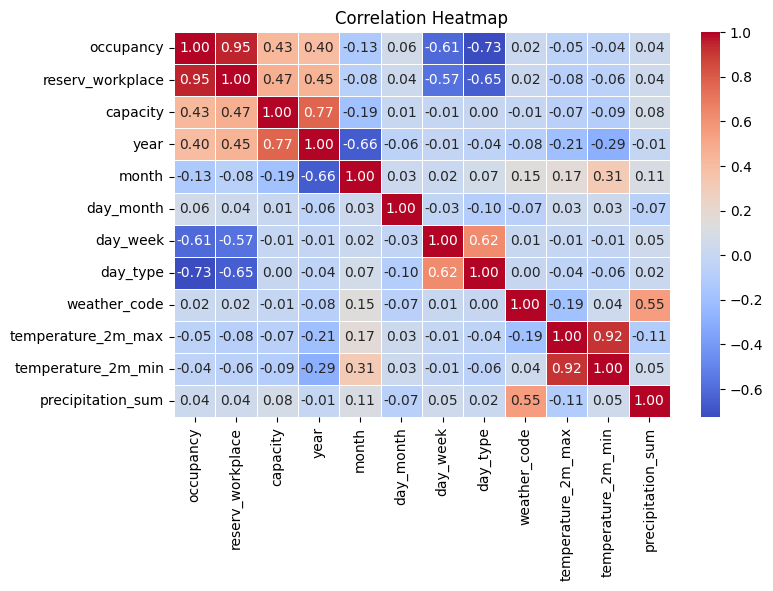

In [17]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
numerical_df = df.select_dtypes(include=[np.number])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

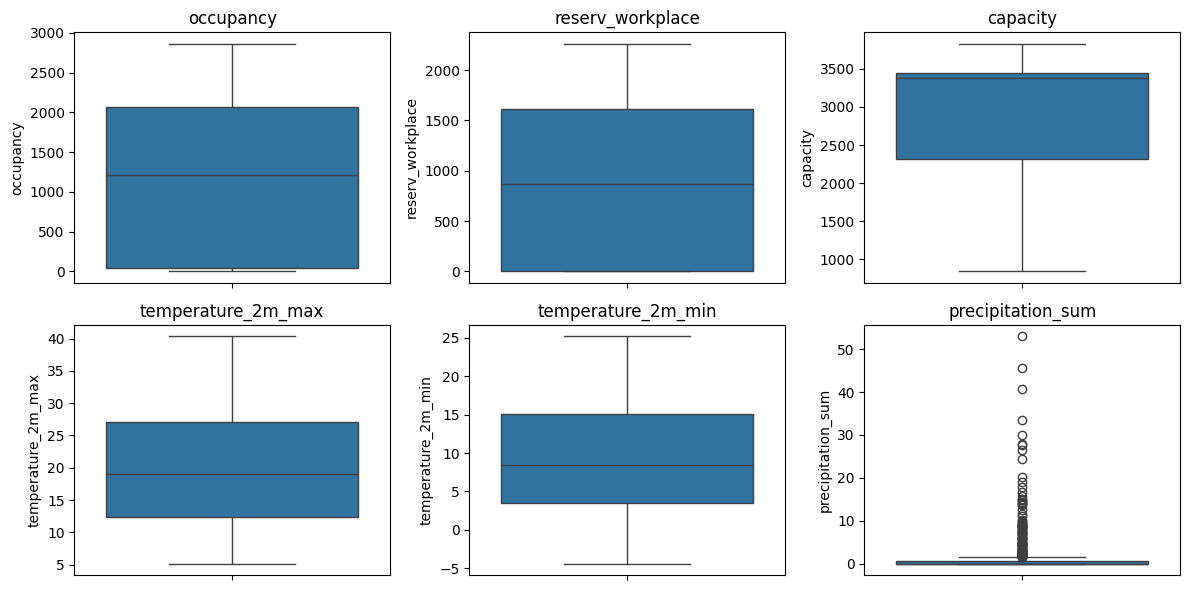

In [18]:
# Distribution of numerical features
numerical_features = df.drop(columns=['year', 'month', 'day_month', 'day_week', 'day_type', 'weather_code'])
num_features = len(numerical_features.columns)
num_rows = (num_features // 3) + (1 if num_features % 3 != 0 else 0)

plt.figure(figsize=(12, 6))
for i, column in enumerate(numerical_features.columns, 1):
    plt.subplot(num_rows, min(3, num_features), i)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

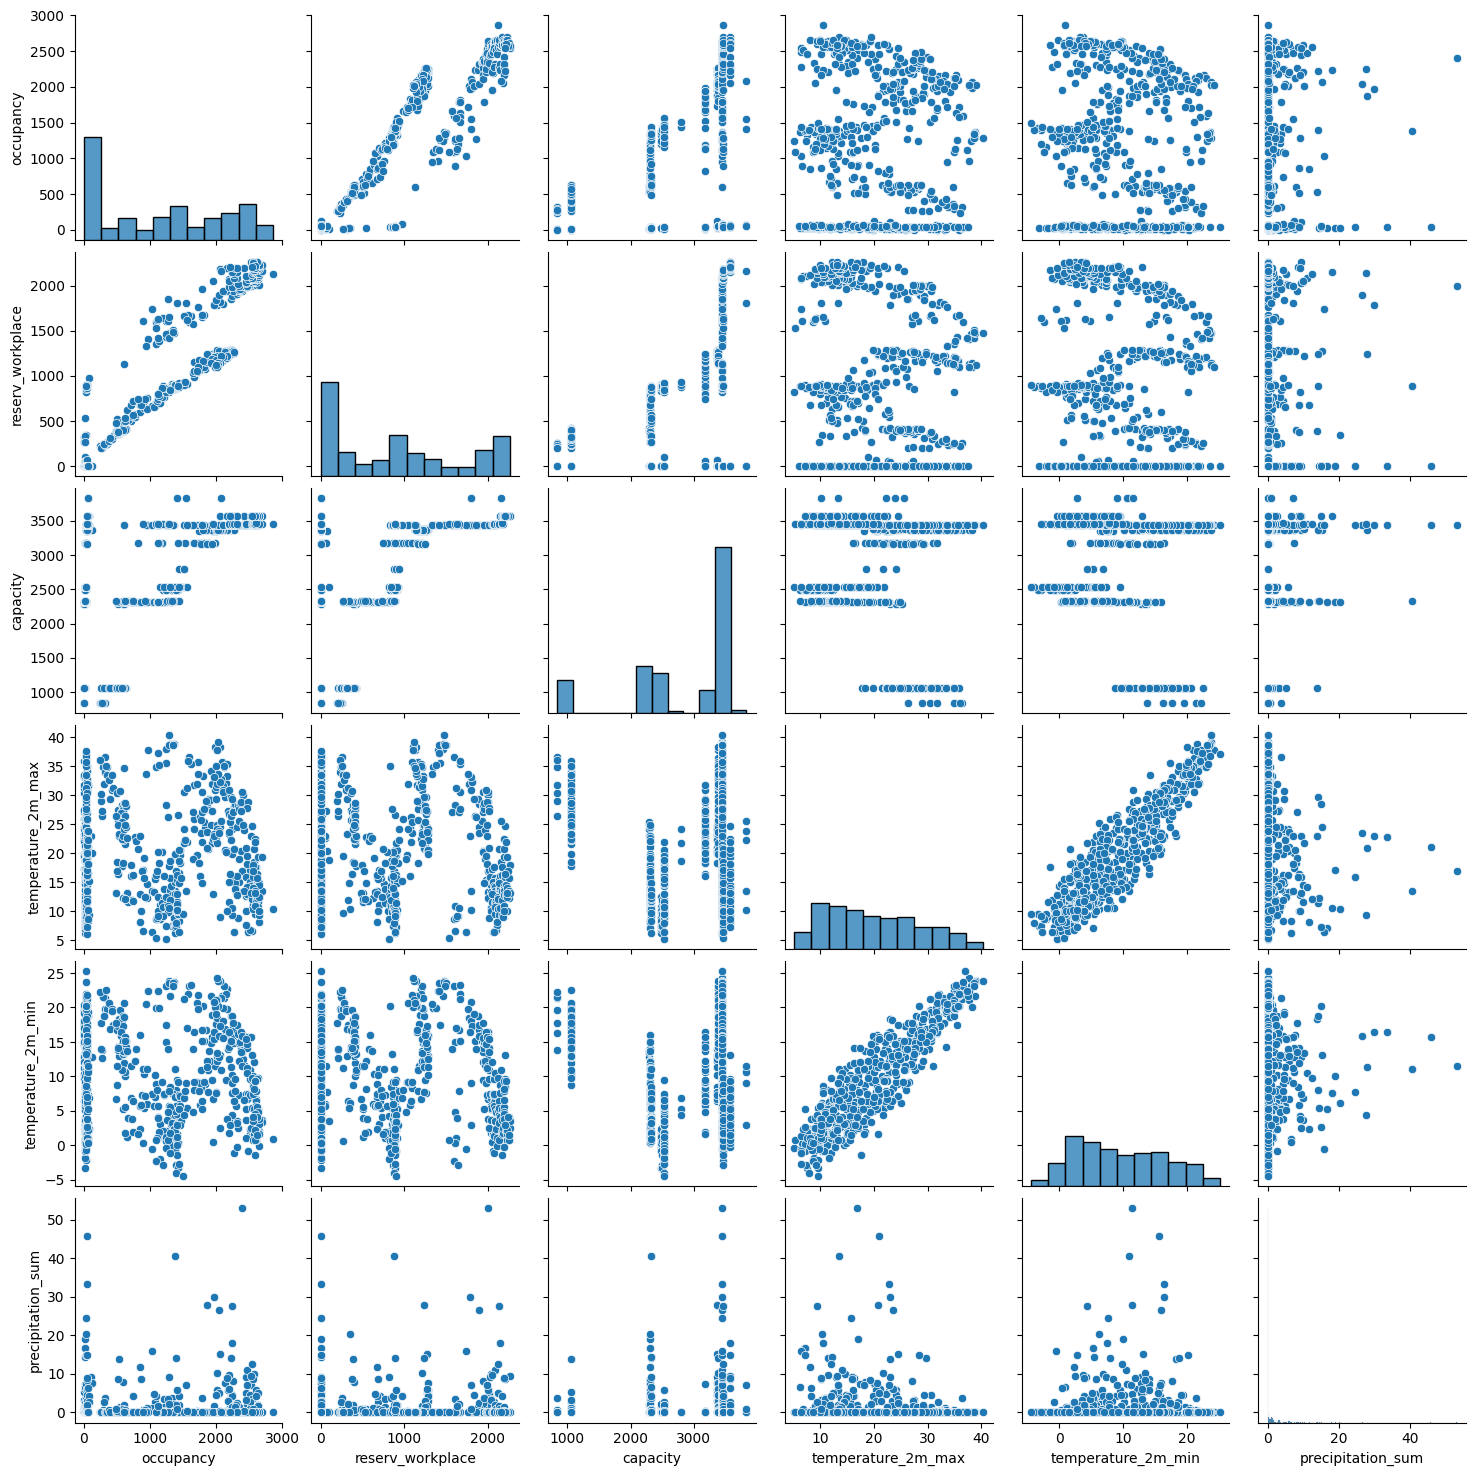

In [19]:
# Pairplot for numerical features
sns.pairplot(df[numerical_features.columns])
plt.show()

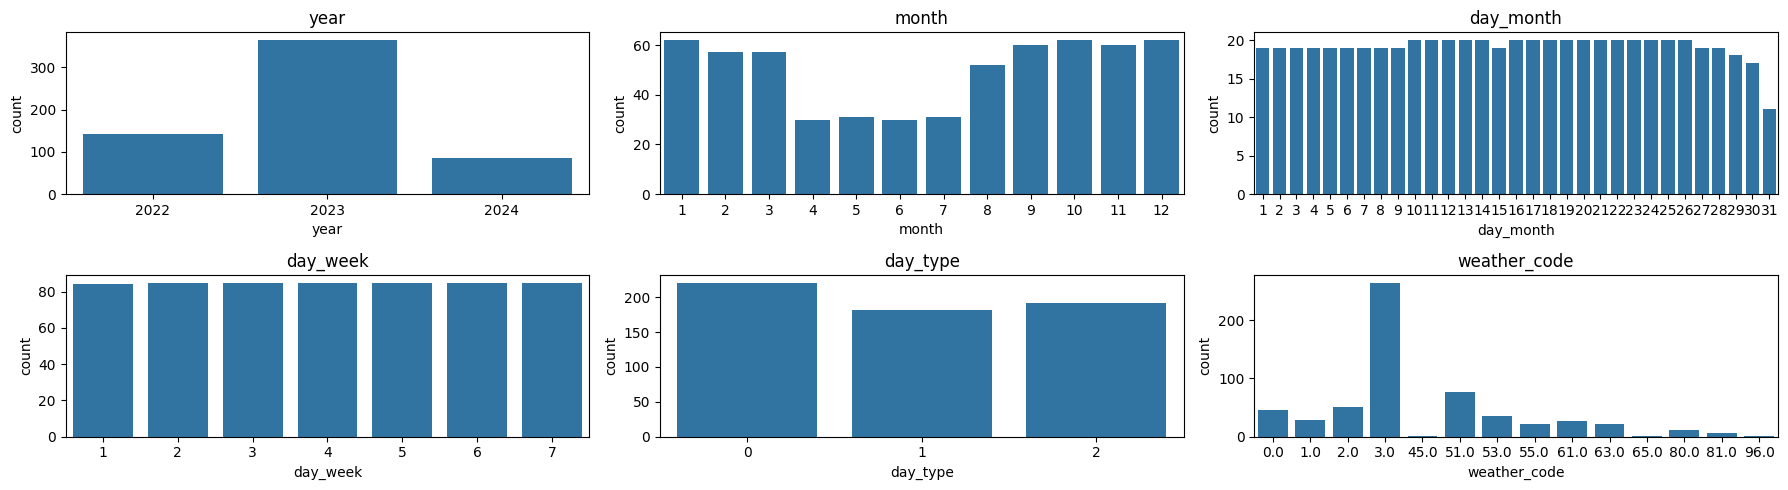

In [20]:
# Countplot for categorical features
categorical_features = df[['year', 'month', 'day_month', 'day_week', 'day_type', 'weather_code']]
num_features = len(categorical_features.columns)
num_rows = (num_features // 3) + (1 if num_features % 3 != 0 else 0)

plt.figure(figsize=(18, 5))
for i, column in enumerate(categorical_features.columns, 1):
    plt.subplot(num_rows, min(3, num_features), i)
    sns.countplot(x=column, data=df)
    plt.title(column)
plt.tight_layout()
plt.show()


### Model selection

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [216]:
occupancy_df = final_df[['occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week','day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
# occupancy_df = occupancy_df.drop(columns=['date'])
# occupancy_df = occupancy_df.reset_index(drop=True)

#### Preprocessing steps

In [217]:
# Last natural year
occupancy_df = occupancy_df[(occupancy_df['date']>= "2023-03-01") & (occupancy_df['date']< "2024-03-01")]
occupancy_df = occupancy_df.drop(columns=['date'])

In [221]:
# Proportion encoding: categorical nominal
proportion_encoding = occupancy_df['weather_code'].value_counts(normalize=True)
occupancy_df['weather_code'] = occupancy_df['weather_code'].map(proportion_encoding)

In [202]:
# this preprocessing is decided to not be used
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Fit the scaler on selected columns and transform them
occupancy_df[['reserv_workplace', 'capacity', 'year', 'month','day_month', 'day_week', 'day_type', 'weather_code', 'temperature_2m_max','temperature_2m_min', 'precipitation_sum']] = scaler.fit_transform(occupancy_df[['reserv_workplace', 'capacity', 'year', 'month','day_month', 'day_week', 'day_type', 'weather_code', 'temperature_2m_max','temperature_2m_min', 'precipitation_sum']])

# occupancy_df

#### Functions definitions

In [162]:
def plot_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test):
    
    # training data
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true_train, y_pred_train, s=15, color='blue', label='Training')
    plt.plot([min(y_true_train), max(y_true_train)], [min(y_true_train), max(y_true_train)], color='red', linestyle='--')
    plt.xlabel('True Occupancy')
    plt.ylabel('Predicted Occupancy')
    plt.title('Predicted vs. True (Training)')
    plt.legend()

    # testing data
    plt.subplot(1, 2, 2)
    plt.scatter(y_true_test, y_pred_test, s=15, color='green', label='Test')
    plt.plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], color='red', linestyle='--')
    plt.xlabel('True Occupancy')
    plt.ylabel('Predicted Occupancy')
    plt.title('Predicted vs. True (Testing)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [164]:
def train_regressor(name, model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)

    # Predictions on train set
    train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_mape = mean_absolute_percentage_error(y_train, train_pred)
    
    # Predictions on test set
    test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)
    
    print(f"Model: {name}")
    print(f"Train MSE: {train_mse}")
    print(f"Train Mean Absolute Error: {train_mae}")
    print(f"Train Mean Absolute % Error: {train_mape}")
    print(f"\nTest MSE: {test_mse}")
    print(f"Test Mean Absolute Error: {test_mae}")
    print(f"Test Mean Absolute % Error: {test_mape}")

    plot_predictions(y_train, train_pred, y_test, test_pred)  

#### Models performance

In [211]:
X = occupancy_df.drop(columns=['occupancy'])
y = occupancy_df['occupancy']

# set shuffle to False to train past and test in most recent, due to date-based data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Model: Linear Regression
Train MSE: 73556.97388087721
Train Mean Absolute Error: 201.0547154985425
Train Mean Absolute % Error: 1.5334788425962047

Test MSE: 620203.3201390941
Test Mean Absolute Error: 708.8465268176893
Test Mean Absolute % Error: 4.509079906174803


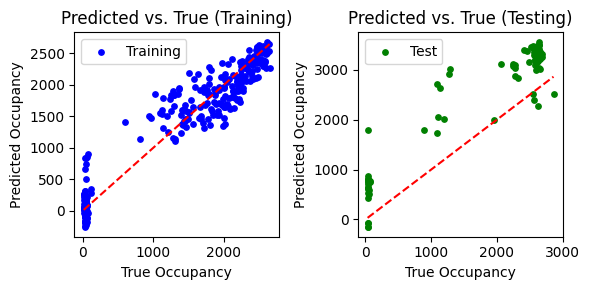

Model: Lasso Regression
Train MSE: 73601.21414372177
Train Mean Absolute Error: 201.34512055506892
Train Mean Absolute % Error: 1.5421871143898942

Test MSE: 616426.4367494684
Test Mean Absolute Error: 706.2934164970434
Test Mean Absolute % Error: 4.486908576128417


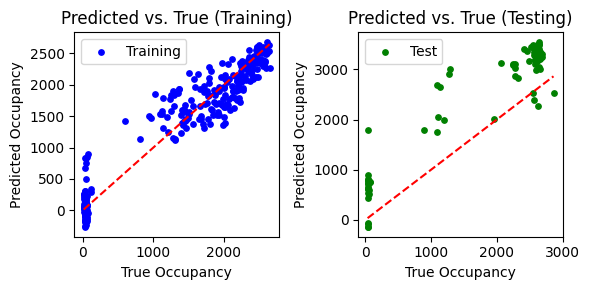

Model: Ridge Regression
Train MSE: 73561.64224585709
Train Mean Absolute Error: 201.05491320847602
Train Mean Absolute % Error: 1.5417003300317078

Test MSE: 622579.6587028315
Test Mean Absolute Error: 710.5104345811877
Test Mean Absolute % Error: 4.51796993512889


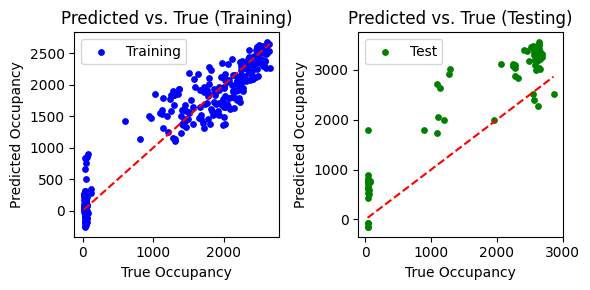

Model: Random Forest
Train MSE: 1686.8386359589042
Train Mean Absolute Error: 19.074006849315076
Train Mean Absolute % Error: 0.03688210783996444

Test MSE: 24286.941767567572
Test Mean Absolute Error: 96.65837837837839
Test Mean Absolute % Error: 0.13123076575393922


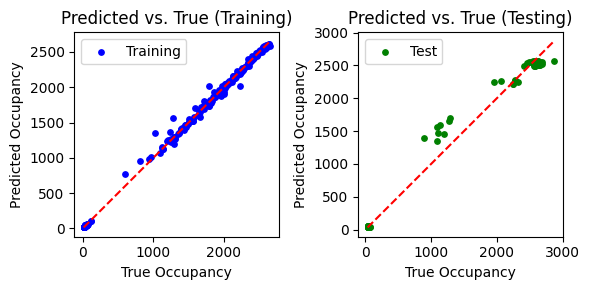

Model: XGBoost
Train MSE: 0.031649911105114996
Train Mean Absolute Error: 0.12166604603806587
Train Mean Absolute % Error: 0.0010287517446940628

Test MSE: 16496.452003147282
Test Mean Absolute Error: 83.49790006070523
Test Mean Absolute % Error: 0.10988899010453816


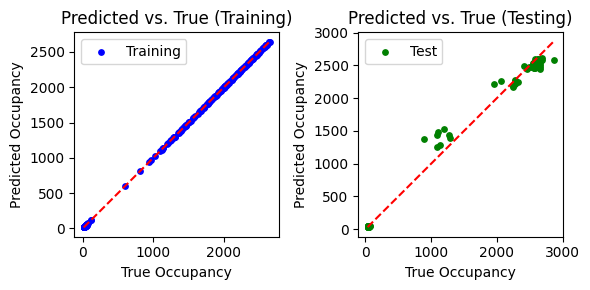

In [210]:
# TRAIN MODELS AND PLOT RESULTS
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor()
}


for name, model in models.items():
    train_regressor(name, model, X_train, X_test, y_train, y_test)

### Selected models and preprocessing

In [168]:
occupancy_df = final_df[['occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week','day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]

# Last natural year
occupancy_df = occupancy_df[(occupancy_df['date']>= "2023-03-01") & (occupancy_df['date']< "2024-03-01")]
occupancy_df = occupancy_df.drop(columns=['date'])

# Proportion encoding: categorical nominal
proportion_encoding = occupancy_df['weather_code'].value_counts(normalize=True)
occupancy_df['weather_code'] = occupancy_df['weather_code'].map(proportion_encoding)

# split train test
X = occupancy_df.drop(columns=['occupancy'])
y = occupancy_df['occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Hyperparameter tunning

Model: Random Forest
Train MSE: 2105.2409795563085
Train Mean Absolute Error: 22.990141833376985
Train Mean Absolute % Error: 0.04218387433179253

Test MSE: 21996.19839691129
Test Mean Absolute Error: 92.90612434698721
Test Mean Absolute % Error: 0.1237283784625874


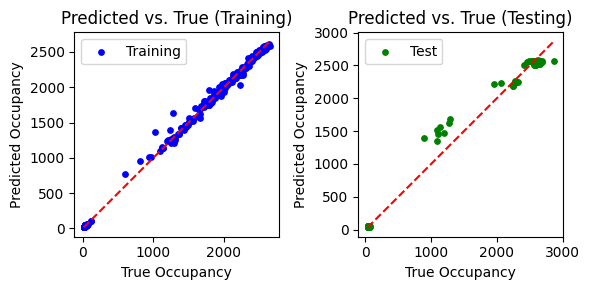

Model: XGBoost
Train MSE: 9.435955296680335
Train Mean Absolute Error: 1.873765909508483
Train Mean Absolute % Error: 0.01306847658773615

Test MSE: 9607.914819887916
Test Mean Absolute Error: 70.06966946576092
Test Mean Absolute % Error: 0.1641505321492498


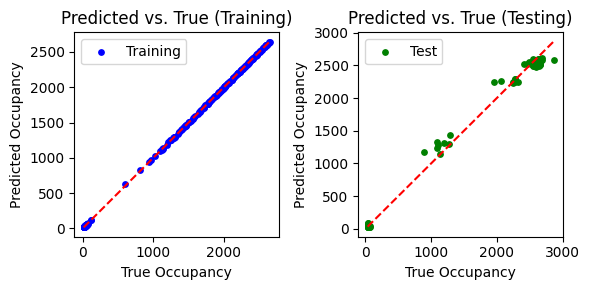

In [163]:
# TRAIN MODELS AND PLOT RESULTS

models = {
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42),
    'XGBoost': xgb.XGBRegressor(learning_rate=0.2, max_depth=7, min_child_weight=4, gamma=8) #bajo learning_rate porque veo overfitting
}

for name, model in models.items():
    train_regressor(name, model, X_train, X_test, y_train, y_test)

### Sliding Window

In [169]:
# Construct 2 data sets with 1 and 2 previous columns respectively
slid_occupancy_df1 = occupancy_df.copy()
slid_occupancy_df1['occupancy_prev1'] = slid_occupancy_df1['occupancy'].shift(1)
slid_occupancy_df1 = slid_occupancy_df1[1:]

slid_occupancy_df2 = slid_occupancy_df1.copy()
slid_occupancy_df2['occupancy_prev2'] = slid_occupancy_df2['occupancy_prev1'].shift(1)
slid_occupancy_df2 = slid_occupancy_df2[1:]

slid_occupancy_df3 = slid_occupancy_df2.copy()
slid_occupancy_df3['occupancy_prev3'] = slid_occupancy_df3['occupancy_prev2'].shift(1)
slid_occupancy_df3 = slid_occupancy_df3[1:]

# slid_occupancy_df2

Training for: Sliding window size 1 data
Model: Random Forest
Train MSE: 2037.6151784009069
Train Mean Absolute Error: 24.448720567611602
Train Mean Absolute % Error: 0.04124067046064924

Test MSE: 18949.80824637954
Test Mean Absolute Error: 84.0993247453872
Test Mean Absolute % Error: 0.111643531560022


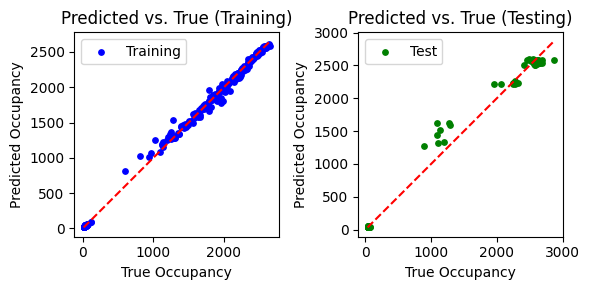

Training for: Sliding window size 1 data
Model: XGBoost
Train MSE: 9.172680372179068
Train Mean Absolute Error: 1.942919819322351
Train Mean Absolute % Error: 0.012008770378234387

Test MSE: 11161.252469348263
Test Mean Absolute Error: 68.7688344406755
Test Mean Absolute % Error: 0.10724417130942927


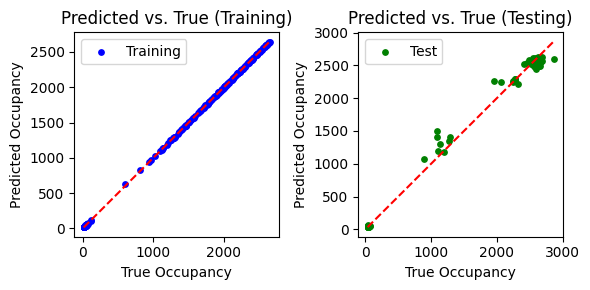

Training for: Sliding window size 2 data
Model: Random Forest
Train MSE: 2519.1339807402655
Train Mean Absolute Error: 26.99359495496872
Train Mean Absolute % Error: 0.04496527635293925

Test MSE: 12253.08258949696
Test Mean Absolute Error: 72.9008167977211
Test Mean Absolute % Error: 0.09325447167961383


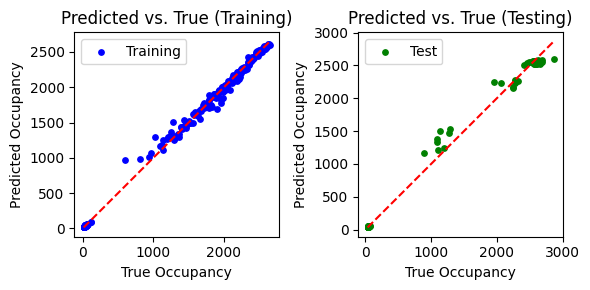

Training for: Sliding window size 2 data
Model: XGBoost
Train MSE: 6.850244140815145
Train Mean Absolute Error: 1.6465502735675406
Train Mean Absolute % Error: 0.012402300047768433

Test MSE: 6498.2581382994895
Test Mean Absolute Error: 51.274261552993565
Test Mean Absolute % Error: 0.10000127792623813


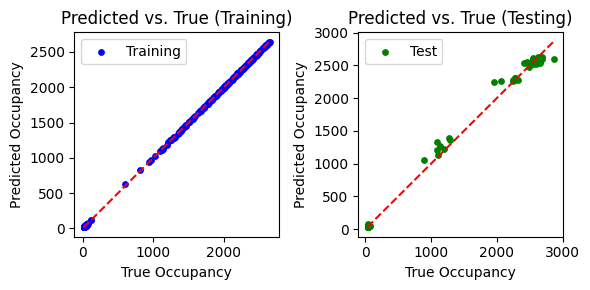

Training for: Sliding window size 3 data
Model: Random Forest
Train MSE: 1939.0995615784536
Train Mean Absolute Error: 24.946844215132415
Train Mean Absolute % Error: 0.06152975654903237

Test MSE: 22476.577657319038
Test Mean Absolute Error: 94.69882652456268
Test Mean Absolute % Error: 0.171463475140488


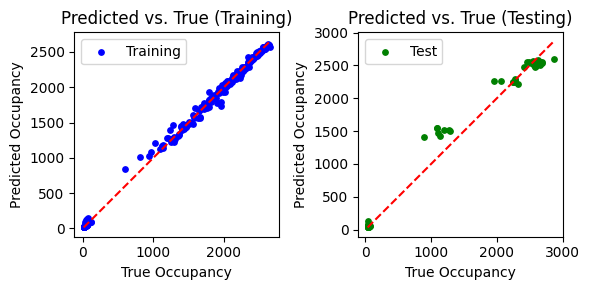

Training for: Sliding window size 3 data
Model: XGBoost
Train MSE: 8.422420340734371
Train Mean Absolute Error: 1.8151758424166975
Train Mean Absolute % Error: 0.014499651688176086

Test MSE: 23861.586555515718
Test Mean Absolute Error: 85.4103387545233
Test Mean Absolute % Error: 0.11551045792145266


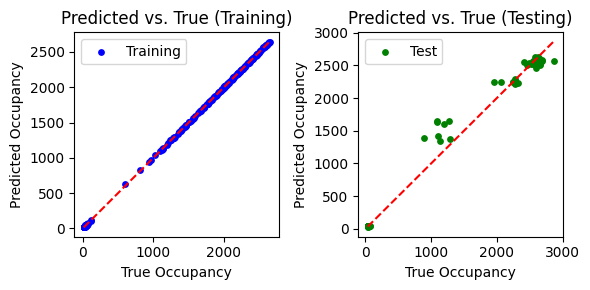

In [170]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42),
    'XGBoost': xgb.XGBRegressor(learning_rate=0.2, max_depth=7, min_child_weight=4, gamma=8)
}

dfs = {
    'Sliding window size 1 data': slid_occupancy_df1,
    'Sliding window size 2 data': slid_occupancy_df2,
    'Sliding window size 3 data': slid_occupancy_df3
}

for df_name, df in dfs.items():

    X = df.drop(columns=['occupancy'])
    y = df['occupancy']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    for model_name, model in models.items():
        print(f'Training for: {df_name}')
        train_regressor(model_name, model, X_train, X_test, y_train, y_test)

## Model generalization

In [269]:
import pandas as pd
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Read dataset
final_df = pd.read_csv(path+"final_df_all.csv")

#### Definition of funcions

In [249]:
def plot_metrics_evolution(dates, mae_list, mse_list):

    fig, ax1 = plt.subplots()

    # Plot MAE
    ax1.plot(dates, mae_list, label='MAE', color='tab:blue', marker='o')
    ax1.set_ylabel('MAE', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(range(len(dates)))
    ax1.set_xticklabels(dates, rotation=45, ha='right')
    ax1.set_ylim(0, 120)
     
    # Plot MSE
    ax2 = ax1.twinx()
    ax2.plot(dates, mse_list, label='MSE', color='tab:red', marker='s')
    ax2.set_ylabel('MSE', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 14000)
    
    # Plot averages
    avg_mae = sum(mae_list) / len(mae_list)
    avg_mse = sum(mse_list) / len(mse_list)
    ax1.axhline(y=avg_mae, color='tab:blue', linestyle='--', label='Avg MAE', alpha=0.5)
    ax2.axhline(y=avg_mse, color='tab:red', linestyle='--', label='Avg MSE', alpha=0.5)
    
    plt.show()

    return avg_mae, avg_mse

In [274]:
def predict_occupancy(dataset, start_date, end_date):
    
    # Filter dataset for 1 year before the prediction
    one_year_bf = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=367)).strftime("%Y-%m-%d") # Calculate one year before the start date
    train_set = dataset[(dataset['date'] >= one_year_bf) & (dataset['date'] < start_date)]
    train_set = train_set.drop(columns=['date'])
    
    # Proportion encoding for weather_code
    proportion_encoding = train_set['weather_code'].value_counts(normalize=True)
    train_set['weather_code'] = train_set['weather_code'].map(proportion_encoding)

    # Sliding window
    # train_set = train_set.copy()
    for i in range(1, 3):
        train_set[f'occupancy_prev{i}'] = train_set['occupancy'].shift(i)
    train_set = train_set.dropna() #this drops the 2 oldest days

    # Prepare features and target variable
    X = train_set.drop(columns=['occupancy'])
    y = train_set['occupancy']
    
    # Get data to be predicted
    new_data = dataset[(dataset['date'] >= start_date) & (dataset['date'] <= end_date)]
    x_pred = new_data.drop(columns=['date', 'occupancy'])
    y_pred = new_data['occupancy']

    predicted_values = []
    mae_list = []
    mse_list = []
    dates = []
    date = start_date

    # Initialize and fit model
    xgb_model = xgb.XGBRegressor(learning_rate=0.2, max_depth=7, min_child_weight=4, gamma=8)
    xgb_model.fit(X, y)

    # Predict occupancy for each day using sliding window
    for idx, day_data in x_pred.iterrows():
        day_data['occupancy_prev1'] = y.iloc[-1]
        day_data['occupancy_prev2'] = y.iloc[-2]
        day_data = pd.DataFrame(day_data).transpose()

        # Predict occupancy for the current day
        occupancy_prediction = xgb_model.predict(day_data)

        # Store the predicted occupancy value in the original dataset
        dataset.at[idx, 'predicted_occupancy'] = occupancy_prediction[0]
        predicted_values.append(occupancy_prediction[0])

        try:
            # Calculate MAE and MSE for the current prediction
            mae = mean_absolute_error([y_pred[idx]], occupancy_prediction)
            mse = mean_squared_error([y_pred[idx]], occupancy_prediction)
            mae_list.append(mae)
            mse_list.append(mse)
    
            print("\nDay:", date)
            print("Predicted Occupancy:", occupancy_prediction)
            print("True Occupancy:", y_pred[idx])
    
            # Store the corresponding date
            dates.append(date)
    
            # Add predicted value to target variable
            y = pd.concat([y, pd.Series(occupancy_prediction[0])], ignore_index=True)
    
            # Move to the next date
            date = datetime.strptime(date, '%Y-%m-%d')
            date += timedelta(days=1)
            date = date.strftime('%Y-%m-%d')
        except:
            pass

    try:
        
        # Plot results and store average of metrics
        avg_mae, avg_mse = plot_metrics_evolution(dates, mae_list, mse_list)
    
        print("\nAverage MAE:", avg_mae)
        print("Average MSE:", avg_mse)
    
        # Plot Predicted and True Values
        plt.figure(figsize=(10, 5))
        plt.plot(dates, predicted_values, label='Predicted', color='tab:orange', marker='o')
        plt.plot(dates, y_pred, label='True', color='tab:green', marker='^')
        plt.xlabel('Date')
        plt.ylabel('Occupancy')
        plt.title('Predicted vs True Occupancy')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except:
        pass


### Total occupancy

C:\Users\gestran_bec\AppData\Local\Temp\ipykernel_9700\455792758.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.at[idx, 'predicted_occupancy'] = occupancy_prediction[0]



Day: 2024-03-01
Predicted Occupancy: [2203.101]
True Occupancy: 2313.0

Day: 2024-03-02
Predicted Occupancy: [49.11451]
True Occupancy: 68.0

Day: 2024-03-03
Predicted Occupancy: [41.414265]
True Occupancy: 56.0

Day: 2024-03-04
Predicted Occupancy: [2601.771]
True Occupancy: 2601.0

Day: 2024-03-05
Predicted Occupancy: [2596.37]
True Occupancy: 2655.0

Day: 2024-03-06
Predicted Occupancy: [2581.5522]
True Occupancy: 2591.0

Day: 2024-03-07
Predicted Occupancy: [2534.0623]
True Occupancy: 2538.0

Day: 2024-03-08
Predicted Occupancy: [2247.9478]
True Occupancy: 2163.0

Day: 2024-03-09
Predicted Occupancy: [56.67332]
True Occupancy: 51.0

Day: 2024-03-10
Predicted Occupancy: [42.98758]
True Occupancy: 42.0

Day: 2024-03-11
Predicted Occupancy: [2631.394]
True Occupancy: 2591.0

Day: 2024-03-12
Predicted Occupancy: [2702.2922]
True Occupancy: 2616.0

Day: 2024-03-13
Predicted Occupancy: [2629.6028]
True Occupancy: 2567.0

Day: 2024-03-14
Predicted Occupancy: [2598.531]
True Occupancy: 25

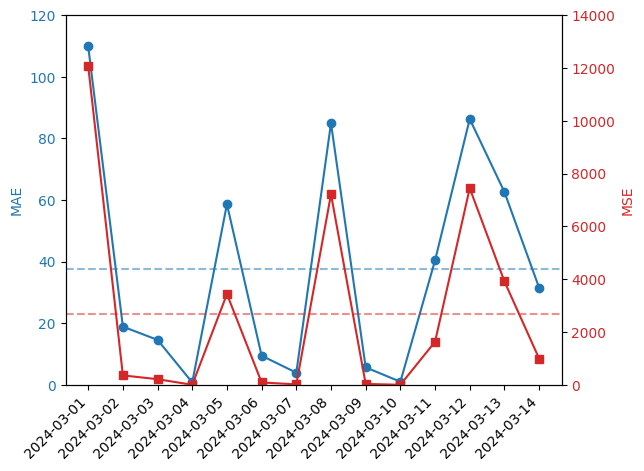


Average MAE: 37.75608934674944
Average MSE: 2673.616222557568


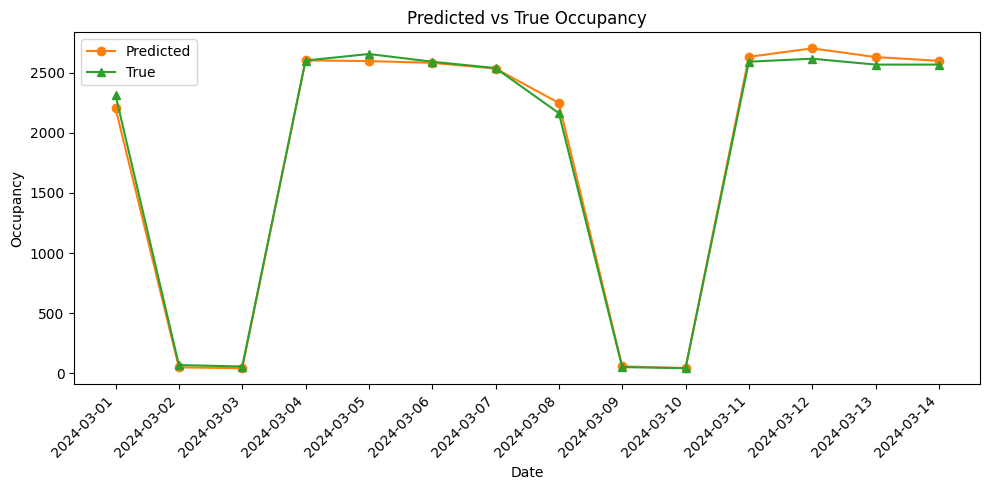

In [275]:
# Example usage:
total_occ_df = final_df[['occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]

predict_occupancy(total_occ_df, "2024-03-01", "2024-03-14")

### Workplace occupancy


Day: 2024-03-01
Predicted Occupancy: [1766.2483]
True Occupancy: 1854.0

Day: 2024-03-02
Predicted Occupancy: [28.012106]
True Occupancy: 22.0

Day: 2024-03-03
Predicted Occupancy: [16.478407]
True Occupancy: 21.0

Day: 2024-03-04
Predicted Occupancy: [2054.805]
True Occupancy: 1978.0

Day: 2024-03-05
Predicted Occupancy: [2074.1055]
True Occupancy: 1991.0

Day: 2024-03-06
Predicted Occupancy: [2011.2318]
True Occupancy: 1962.0

Day: 2024-03-07
Predicted Occupancy: [1965.5223]
True Occupancy: 1963.0

Day: 2024-03-08
Predicted Occupancy: [1789.5825]
True Occupancy: 1709.0

Day: 2024-03-09
Predicted Occupancy: [25.63657]
True Occupancy: 22.0

Day: 2024-03-10
Predicted Occupancy: [18.33022]
True Occupancy: 14.0

Day: 2024-03-11
Predicted Occupancy: [2047.3467]
True Occupancy: 2030.0

Day: 2024-03-12
Predicted Occupancy: [2052.2476]
True Occupancy: 2010.0

Day: 2024-03-13
Predicted Occupancy: [1985.2891]
True Occupancy: 1927.0

Day: 2024-03-14
Predicted Occupancy: [1958.3016]
True Occupan

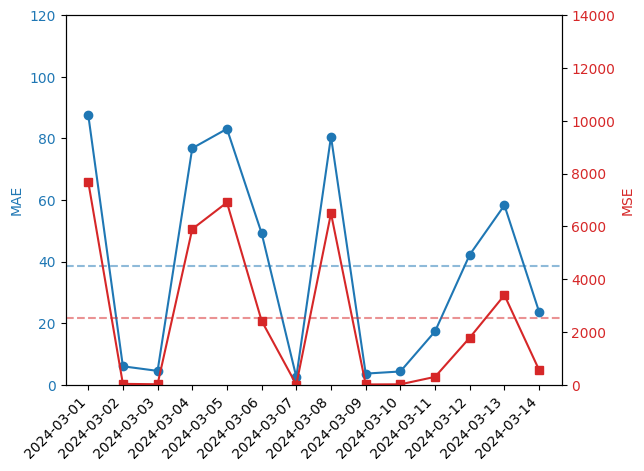


Average MAE: 38.57720947265625
Average MSE: 2540.2222317437786


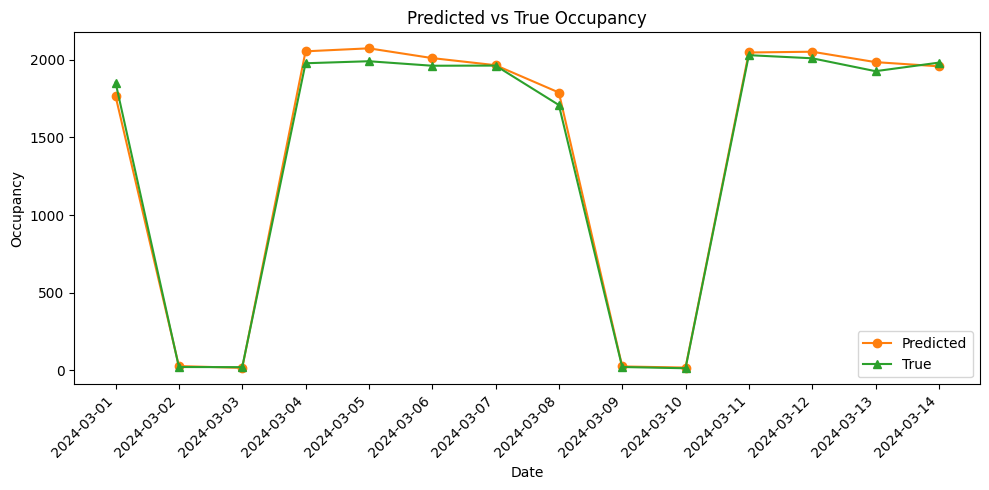

In [204]:
# Case of use 1: workplace occupancy

workplace_occup_df = final_df[['occup_workplaces', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
workplace_occup_df = workplace_occup_df.rename(columns={'occup_workplaces': 'occupancy'})

predict_occupancy(workplace_occup_df, "2024-03-01", "2024-03-14")


Day: 2024-03-01
Predicted Occupancy: [1757.6311]
True Occupancy: 1854.0

Day: 2024-03-02
Predicted Occupancy: [16.590757]
True Occupancy: 22.0

Day: 2024-03-03
Predicted Occupancy: [8.939788]
True Occupancy: 21.0

Day: 2024-03-04
Predicted Occupancy: [1986.3241]
True Occupancy: 1978.0

Day: 2024-03-05
Predicted Occupancy: [1984.9615]
True Occupancy: 1991.0

Day: 2024-03-06
Predicted Occupancy: [1979.7533]
True Occupancy: 1962.0

Day: 2024-03-07
Predicted Occupancy: [1933.8348]
True Occupancy: 1963.0

Day: 2024-03-08
Predicted Occupancy: [1782.0798]
True Occupancy: 1709.0

Day: 2024-03-09
Predicted Occupancy: [18.577915]
True Occupancy: 22.0

Day: 2024-03-10
Predicted Occupancy: [13.557052]
True Occupancy: 14.0

Day: 2024-03-11
Predicted Occupancy: [2018.8649]
True Occupancy: 2030.0

Day: 2024-03-12
Predicted Occupancy: [2106.4863]
True Occupancy: 2010.0

Day: 2024-03-13
Predicted Occupancy: [1985.7692]
True Occupancy: 1927.0

Day: 2024-03-14
Predicted Occupancy: [1952.2213]
True Occup

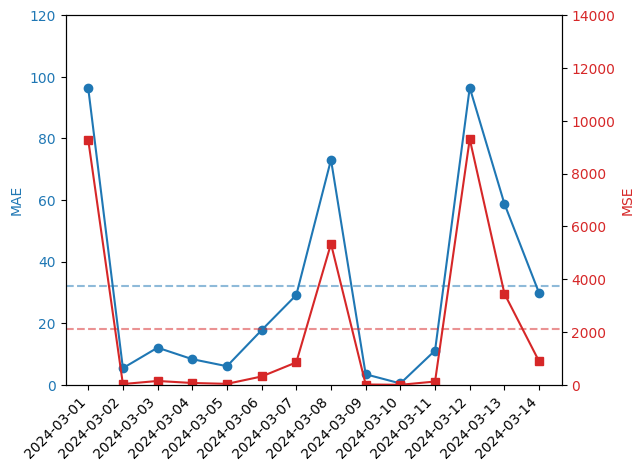


Average MAE: 32.01668112618582
Average MSE: 2132.8549336134615


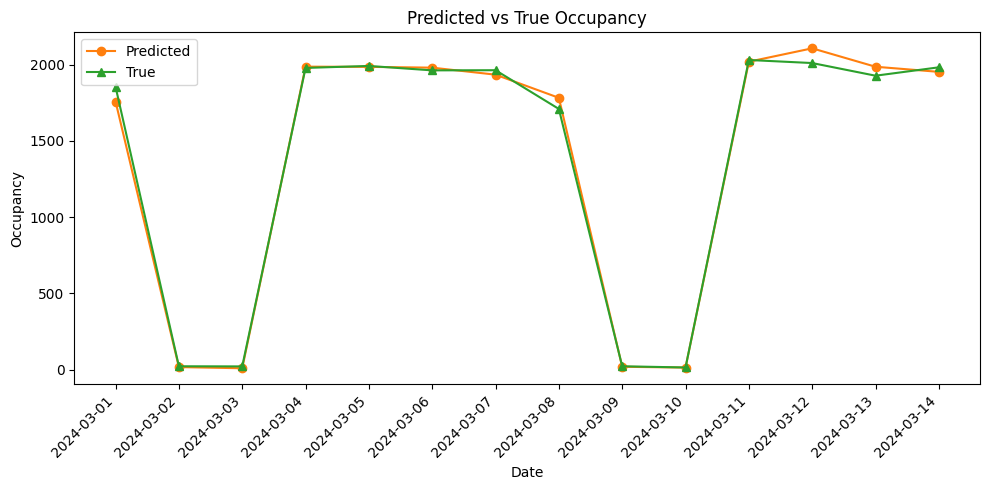

In [235]:
# Case of use 1.0: workplace occupancy WITH TOTAL OCCUPANCY PREDICTIONS
# Retrieves better results

workplace_occup_df2 = final_df[['occup_workplaces', 'occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
workplace_occup_df2 = workplace_occup_df2.rename(columns={'occupancy': 'occupancy_total'})

# Add predicted total occupancy
workplace_occup_df2 = pd.merge(workplace_occup_df2, total_occ_df[['date', 'predicted_occupancy']], on='date', how='left')
workplace_occup_df2['occupancy_total'] = workplace_occup_df2.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['occupancy_total'], axis=1)
workplace_occup_df2 = workplace_occup_df2.drop(columns=['predicted_occupancy'])

workplace_occup_df2 = workplace_occup_df2.rename(columns={'occup_workplaces': 'occupancy'})

predict_occupancy(workplace_occup_df2, "2024-03-01", "2024-03-14")

### Expected restaurant occupancy


Day: 2024-03-01
Predicted Occupancy: [1880.8806]
True Occupancy: 1960.0

Day: 2024-03-02
Predicted Occupancy: [35.928574]
True Occupancy: 34.0

Day: 2024-03-03
Predicted Occupancy: [25.526224]
True Occupancy: 30.0

Day: 2024-03-04
Predicted Occupancy: [2182.9573]
True Occupancy: 2102.0

Day: 2024-03-05
Predicted Occupancy: [2227.0505]
True Occupancy: 2149.0

Day: 2024-03-06
Predicted Occupancy: [2150.565]
True Occupancy: 2113.0

Day: 2024-03-07
Predicted Occupancy: [2069.916]
True Occupancy: 2104.0

Day: 2024-03-08
Predicted Occupancy: [1885.8927]
True Occupancy: 1818.0

Day: 2024-03-09
Predicted Occupancy: [23.04863]
True Occupancy: 33.0

Day: 2024-03-10
Predicted Occupancy: [26.253103]
True Occupancy: 25.0

Day: 2024-03-11
Predicted Occupancy: [2158.4805]
True Occupancy: 2154.0

Day: 2024-03-12
Predicted Occupancy: [2217.3352]
True Occupancy: 2163.0

Day: 2024-03-13
Predicted Occupancy: [2110.671]
True Occupancy: 2063.0

Day: 2024-03-14
Predicted Occupancy: [2103.8464]
True Occupanc

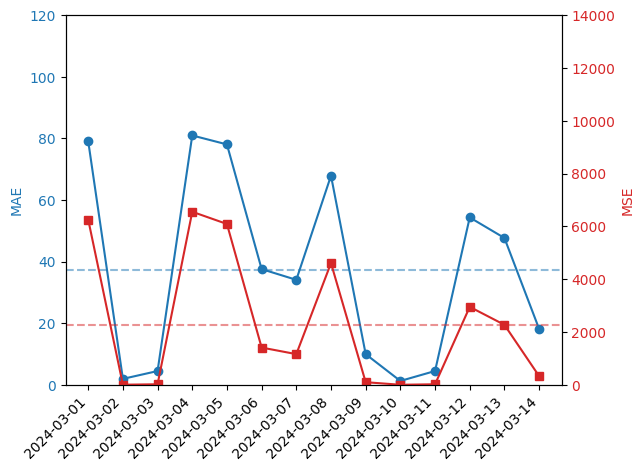


Average MAE: 37.13684163774763
Average MSE: 2270.492504022272


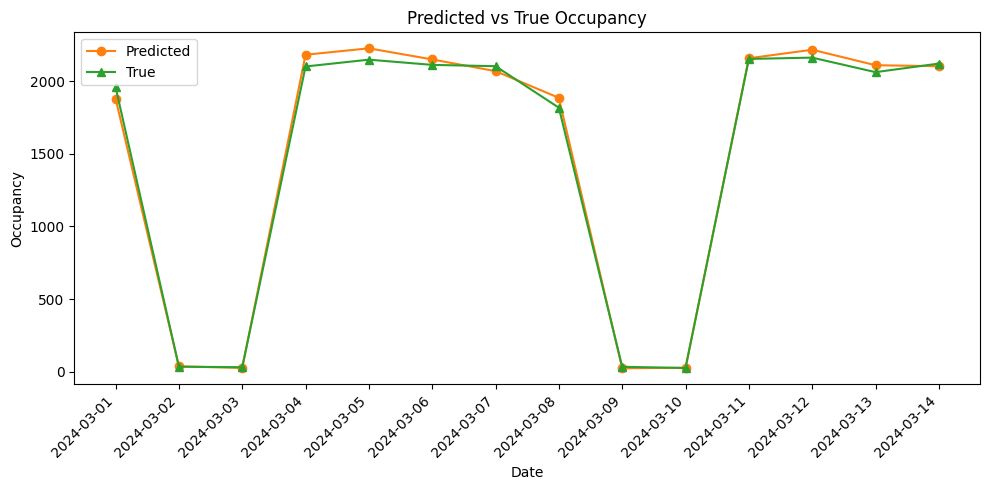

In [205]:
# Case of use 2: occupancy of employees who can eat (have permission)

exp_rest_occup_df = final_df[['exp_occup_restaurant', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
exp_rest_occup_df = exp_rest_occup_df.rename(columns={'exp_occup_restaurant': 'occupancy'})

predict_occupancy(exp_rest_occup_df, "2024-03-01", "2024-03-14")


Day: 2024-03-01
Predicted Occupancy: [1846.4314]
True Occupancy: 1960.0

Day: 2024-03-02
Predicted Occupancy: [28.833439]
True Occupancy: 34.0

Day: 2024-03-03
Predicted Occupancy: [20.868027]
True Occupancy: 30.0

Day: 2024-03-04
Predicted Occupancy: [2122.2725]
True Occupancy: 2102.0

Day: 2024-03-05
Predicted Occupancy: [2129.5142]
True Occupancy: 2149.0

Day: 2024-03-06
Predicted Occupancy: [2124.9768]
True Occupancy: 2113.0

Day: 2024-03-07
Predicted Occupancy: [2062.3418]
True Occupancy: 2104.0

Day: 2024-03-08
Predicted Occupancy: [1876.4009]
True Occupancy: 1818.0

Day: 2024-03-09
Predicted Occupancy: [25.718246]
True Occupancy: 33.0

Day: 2024-03-10
Predicted Occupancy: [23.004776]
True Occupancy: 25.0

Day: 2024-03-11
Predicted Occupancy: [2148.5955]
True Occupancy: 2154.0

Day: 2024-03-12
Predicted Occupancy: [2278.5054]
True Occupancy: 2163.0

Day: 2024-03-13
Predicted Occupancy: [2135.8896]
True Occupancy: 2063.0

Day: 2024-03-14
Predicted Occupancy: [2095.051]
True Occup

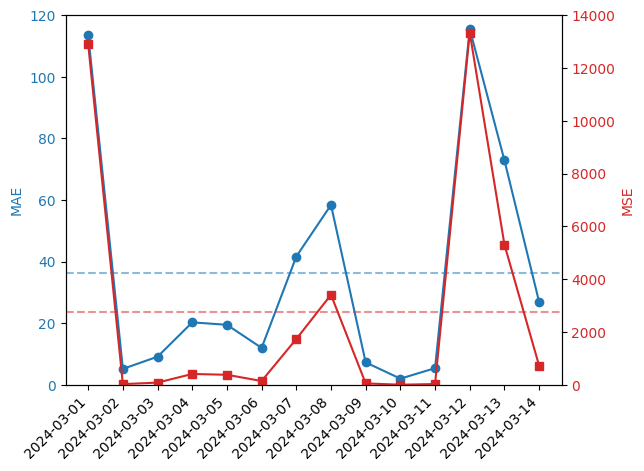


Average MAE: 36.406202861240935
Average MSE: 2753.924986662627


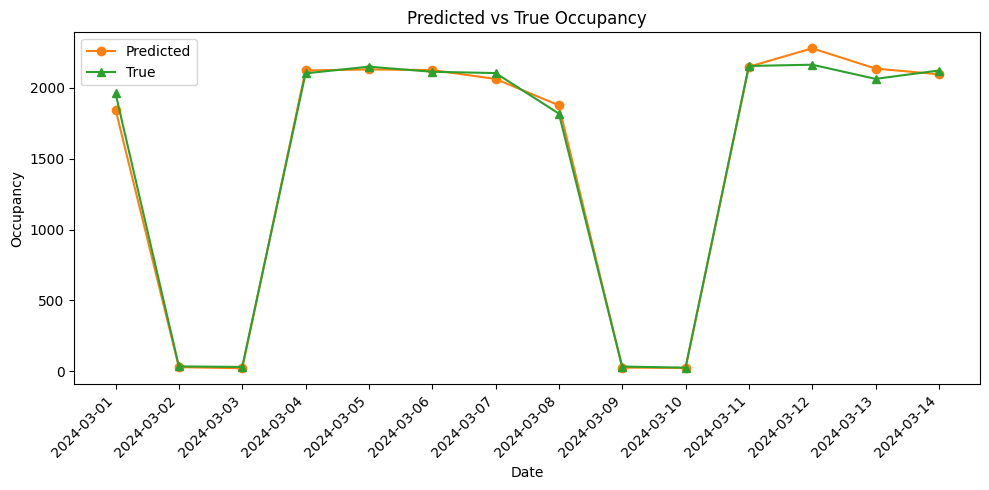

In [246]:
# Case of use 2.0: occupancy of employees who can eat (have permission) WITH TOTAL OCCUPANCY PREDICTIONS
# Retrieves similar results

exp_rest_occup_df2 = final_df[['exp_occup_restaurant', 'occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
exp_rest_occup_df2 = exp_rest_occup_df2.rename(columns={'occupancy': 'occupancy_total'})

# Add predicted total occupancy
exp_rest_occup_df2 = pd.merge(exp_rest_occup_df2, total_occ_df[['date', 'predicted_occupancy']], on='date', how='left')
exp_rest_occup_df2['occupancy_total'] = exp_rest_occup_df2.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['occupancy_total'], axis=1)
exp_rest_occup_df2 = exp_rest_occup_df2.drop(columns=['predicted_occupancy'])

exp_rest_occup_df2 = exp_rest_occup_df2.rename(columns={'exp_occup_restaurant': 'occupancy'})

predict_occupancy(exp_rest_occup_df2, "2024-03-01", "2024-03-14")

### Restaurant occupancy


Day: 2024-03-01
Predicted Occupancy: [-31.847166]
True Occupancy: 0.0

Day: 2024-03-02
Predicted Occupancy: [27.644197]
True Occupancy: 0.0

Day: 2024-03-03
Predicted Occupancy: [15.876634]
True Occupancy: 0.0

Day: 2024-03-04
Predicted Occupancy: [1756.5001]
True Occupancy: 1691.0

Day: 2024-03-05
Predicted Occupancy: [1731.8755]
True Occupancy: 1704.0

Day: 2024-03-06
Predicted Occupancy: [1616.7218]
True Occupancy: 1639.0

Day: 2024-03-07
Predicted Occupancy: [1558.5383]
True Occupancy: 1661.0

Day: 2024-03-08
Predicted Occupancy: [-6.294349]
True Occupancy: 0.0

Day: 2024-03-09
Predicted Occupancy: [-2.0962667]
True Occupancy: 0.0

Day: 2024-03-10
Predicted Occupancy: [2.7136834]
True Occupancy: 0.0

Day: 2024-03-11
Predicted Occupancy: [1731.6012]
True Occupancy: 1728.0

Day: 2024-03-12
Predicted Occupancy: [1728.1056]
True Occupancy: 1686.0

Day: 2024-03-13
Predicted Occupancy: [1669.8634]
True Occupancy: 1648.0

Day: 2024-03-14
Predicted Occupancy: [1633.4481]
True Occupancy: 1

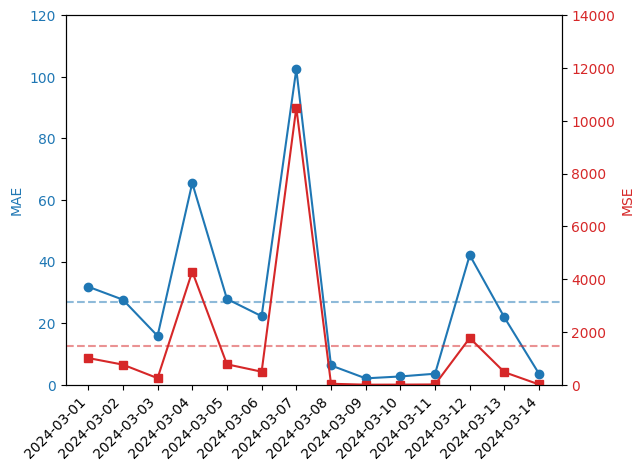


Average MAE: 26.836417521749222
Average MSE: 1458.5987704019894


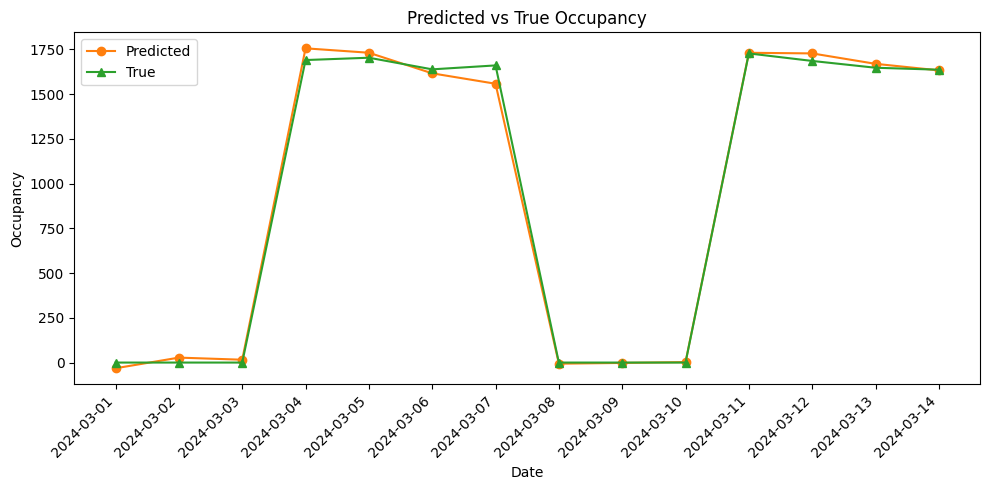

In [207]:
# Case of use 3: restaurant occupancy

rest_occup_df = final_df[['occup_restaurant', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
rest_occup_df = rest_occup_df.rename(columns={'occup_restaurant': 'occupancy'})

predict_occupancy(rest_occup_df, "2024-03-01", "2024-03-14")


Day: 2024-03-01
Predicted Occupancy: [13.280348]
True Occupancy: 0.0

Day: 2024-03-02
Predicted Occupancy: [4.4997215]
True Occupancy: 0.0

Day: 2024-03-03
Predicted Occupancy: [6.01328]
True Occupancy: 0.0

Day: 2024-03-04
Predicted Occupancy: [1718.8182]
True Occupancy: 1691.0

Day: 2024-03-05
Predicted Occupancy: [1758.3079]
True Occupancy: 1704.0

Day: 2024-03-06
Predicted Occupancy: [1608.0985]
True Occupancy: 1639.0

Day: 2024-03-07
Predicted Occupancy: [1575.2152]
True Occupancy: 1661.0

Day: 2024-03-08
Predicted Occupancy: [-4.5553956]
True Occupancy: 0.0

Day: 2024-03-09
Predicted Occupancy: [-5.1696362]
True Occupancy: 0.0

Day: 2024-03-10
Predicted Occupancy: [0.14360514]
True Occupancy: 0.0

Day: 2024-03-11
Predicted Occupancy: [1738.7488]
True Occupancy: 1728.0

Day: 2024-03-12
Predicted Occupancy: [1752.81]
True Occupancy: 1686.0

Day: 2024-03-13
Predicted Occupancy: [1645.53]
True Occupancy: 1648.0

Day: 2024-03-14
Predicted Occupancy: [1617.7344]
True Occupancy: 1637.0

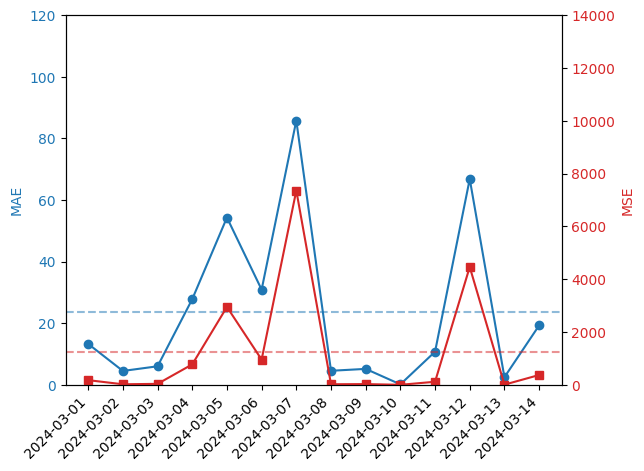


Average MAE: 23.697771270360267
Average MSE: 1233.8419767668286


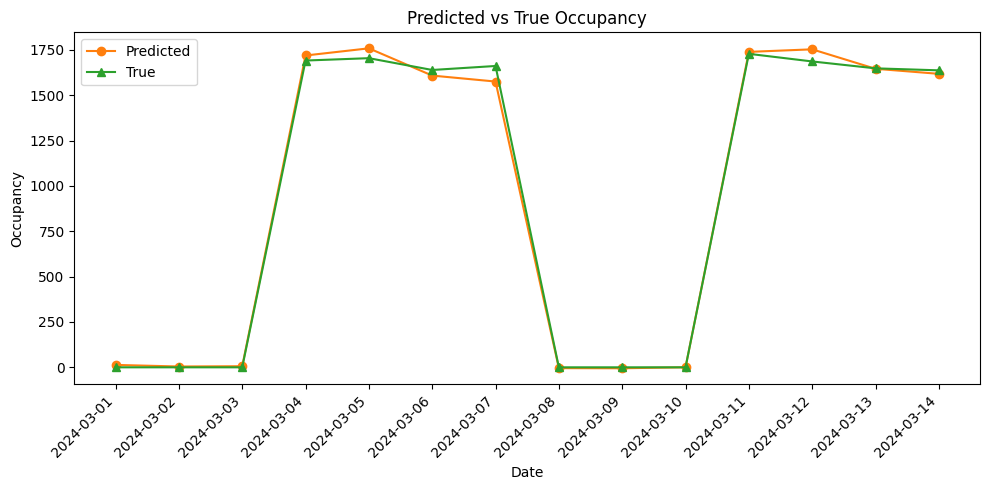

In [236]:
# Case of use 3.2: restaurant occupancy WITH EXPECTED RESTAURANT OCCUPANCY PREDICTIONS
# Retrieves better results

rest_occup_df2 = final_df[['occup_restaurant', 'exp_occup_restaurant', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]

# Add predicted expected occupancy
rest_occup_df2 = pd.merge(rest_occup_df2, exp_rest_occup_df[['date', 'predicted_occupancy']], on='date', how='left')
rest_occup_df2['exp_occup_restaurant'] = rest_occup_df2.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['exp_occup_restaurant'], axis=1)
rest_occup_df2 = rest_occup_df2.drop(columns=['predicted_occupancy'])

rest_occup_df2 = rest_occup_df2.rename(columns={'occup_restaurant': 'occupancy'})

predict_occupancy(rest_occup_df2, "2024-03-01", "2024-03-14")


Day: 2024-03-01
Predicted Occupancy: [21.536283]
True Occupancy: 0.0

Day: 2024-03-02
Predicted Occupancy: [4.4997215]
True Occupancy: 0.0

Day: 2024-03-03
Predicted Occupancy: [6.01328]
True Occupancy: 0.0

Day: 2024-03-04
Predicted Occupancy: [1731.5641]
True Occupancy: 1691.0

Day: 2024-03-05
Predicted Occupancy: [1678.8604]
True Occupancy: 1704.0

Day: 2024-03-06
Predicted Occupancy: [1603.862]
True Occupancy: 1639.0

Day: 2024-03-07
Predicted Occupancy: [1574.4733]
True Occupancy: 1661.0

Day: 2024-03-08
Predicted Occupancy: [-4.5553956]
True Occupancy: 0.0

Day: 2024-03-09
Predicted Occupancy: [-5.1696362]
True Occupancy: 0.0

Day: 2024-03-10
Predicted Occupancy: [0.02754705]
True Occupancy: 0.0

Day: 2024-03-11
Predicted Occupancy: [1735.4807]
True Occupancy: 1728.0

Day: 2024-03-12
Predicted Occupancy: [1752.81]
True Occupancy: 1686.0

Day: 2024-03-13
Predicted Occupancy: [1664.3446]
True Occupancy: 1648.0

Day: 2024-03-14
Predicted Occupancy: [1622.2463]
True Occupancy: 1637.

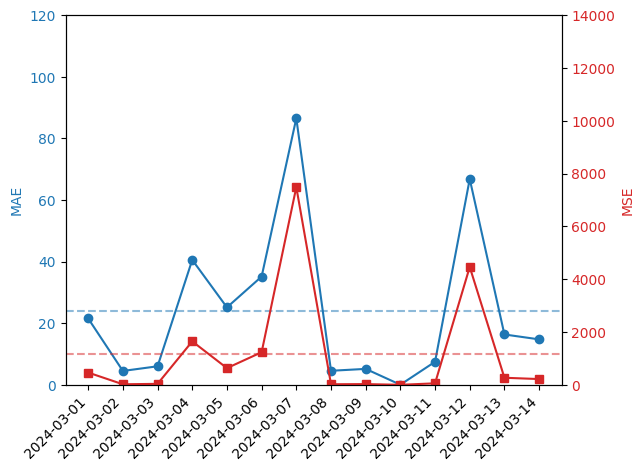


Average MAE: 23.897093580370502
Average MSE: 1183.6467965276315


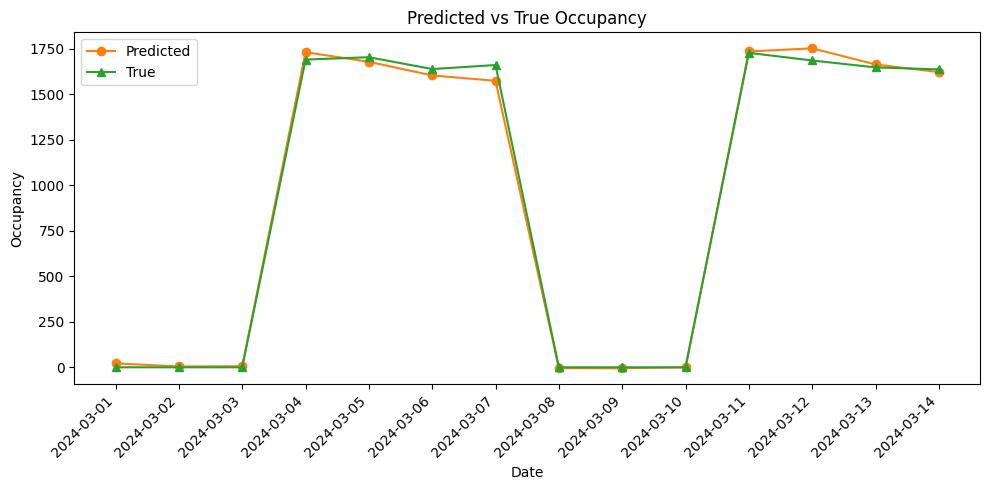

In [247]:
# Case of use 3.2.0: restaurant occupancy WITH EXPECTED RESTAURANT OCCUPANCY PREDICTIONS AND TOTAL OCCUPANCY
# Retrieves same results


# Predict restaurant occupancy with expected restaurant occupancy resulting from before
rest_occup_df3 = final_df[['occup_restaurant', 'exp_occup_restaurant', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]

# Add predicted expected occupancy
rest_occup_df3 = pd.merge(rest_occup_df3, exp_rest_occup_df2[['date', 'predicted_occupancy']], on='date', how='left')
rest_occup_df3['exp_occup_restaurant'] = rest_occup_df3.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['exp_occup_restaurant'], axis=1)
rest_occup_df3 = rest_occup_df3.drop(columns=['predicted_occupancy'])

rest_occup_df3 = rest_occup_df3.rename(columns={'occup_restaurant': 'occupancy'})

predict_occupancy(rest_occup_df3, "2024-03-01", "2024-03-14")

### Store predictions

In [280]:
predictions_df = pd.merge(final_df, total_occ_df[['date', 'predicted_occupancy']], on='date', how='left')
predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_total_occup'})

predictions_df = pd.merge(predictions_df, workplace_occup_df2[['date', 'predicted_occupancy']], on='date', how='left')
predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_workplace_occup'})

predictions_df = pd.merge(predictions_df, exp_rest_occup_df2[['date', 'predicted_occupancy']], on='date', how='left')
predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_exp_rest_occup'})

predictions_df = pd.merge(predictions_df, rest_occup_df3[['date', 'predicted_occupancy']], on='date', how='left')
predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_rest_occup'})

predictions_df[predictions_df['date'] >= "2024-03-01"]

,date,capacity,reserv_workplace,occupancy,occup_workplaces,exp_occup_restaurant,occup_restaurant,day_month,month,year,day_week,day_type,weather_code,temperature_2m_max,temperature_2m_min,precipitation_sum,pred_total_occup,pred_workplace_occup,pred_exp_rest_occup,pred_rest_occup,pred_total_occup,pred_workplace_occup,pred_exp_rest_occup,pred_rest_occup
568,2024-03-01,3571.0,2193.0,2313.0,1854.0,1960.0,0.0,1,3,2024,5,1,3.0,12.776000,-0.274,0.0,2203.101000,1757.631100,1846.431400,21.536283,NaN,NaN,NaN,NaN
569,2024-03-02,3571.0,0.0,68.0,22.0,34.0,0.0,2,3,2024,6,2,63.0,8.226000,0.426,6.4,49.114510,16.590757,28.833439,4.499721,NaN,NaN,NaN,NaN
570,2024-03-03,3571.0,0.0,56.0,21.0,30.0,0.0,3,3,2024,7,2,3.0,8.576000,0.276,0.0,41.414265,8.939788,20.868027,6.013280,NaN,NaN,NaN,NaN
571,2024-03-04,3571.0,2224.0,2601.0,1978.0,2102.0,1691.0,4,3,2024,1,1,3.0,12.726000,2.026,0.0,2601.771000,1986.324100,2122.272500,1731.564100,NaN,NaN,NaN,NaN
572,2024-03-05,3571.0,2231.0,2655.0,1991.0,2149.0,1704.0,5,3,2024,2,0,3.0,12.376000,1.576,0.0,2596.370000,1984.961500,2129.514200,1678.860400,NaN,NaN,NaN,NaN
573,2024-03-06,3571.0,2253.0,2591.0,1962.0,2113.0,1639.0,6,3,2024,3,0,3.0,13.376000,0.826,0.0,2581.552200,1979.753300,2124.976800,1603.862000,NaN,NaN,NaN,NaN
574,2024-03-07,3571.0,2264.0,2538.0,1963.0,2104.0,1661.0,7,3,2024,4,0,63.0,13.126000,2.476,9.4,2534.062300,1933.834800,2062.341800,1574.473300,NaN,NaN,NaN,NaN
575,2024-03-08,3571.0,2198.0,2163.0,1709.0,1818.0,0.0,8,3,2024,5,1,63.0,10.076000,3.876,9.0,2247.947800,1782.079800,1876.400900,-4.555396,NaN,NaN,NaN,NaN
576,2024-03-09,3571.0,0.0,51.0,22.0,33.0,0.0,9,3,2024,6,2,63.0,7.176000,2.726,14.9,56.673320,18.577915,25.718246,-5.169636,NaN,NaN,NaN,NaN
577,2024-03-10,3571.0,0.0,42.0,14.0,25.0,0.0,10,3,2024,7,2,53.0,11.776000,3.826,2.0,42.987580,13.557052,23.004776,0.027547,NaN,NaN,NaN,NaN


In [284]:
predictions_df.to_csv(path+"predictions_df.csv", index=False)

### Best iteration strategy code

C:\Users\gestran_bec\AppData\Local\Temp\ipykernel_9700\455792758.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.at[idx, 'predicted_occupancy'] = occupancy_prediction[0]



Day: 2024-03-01
Predicted Occupancy: [2203.101]
True Occupancy: 2313.0

Day: 2024-03-02
Predicted Occupancy: [49.11451]
True Occupancy: 68.0

Day: 2024-03-03
Predicted Occupancy: [41.414265]
True Occupancy: 56.0

Day: 2024-03-04
Predicted Occupancy: [2601.771]
True Occupancy: 2601.0

Day: 2024-03-05
Predicted Occupancy: [2596.37]
True Occupancy: 2655.0

Day: 2024-03-06
Predicted Occupancy: [2581.5522]
True Occupancy: 2591.0

Day: 2024-03-07
Predicted Occupancy: [2534.0623]
True Occupancy: 2538.0

Day: 2024-03-08
Predicted Occupancy: [2247.9478]
True Occupancy: 2163.0

Day: 2024-03-09
Predicted Occupancy: [56.67332]
True Occupancy: 51.0

Day: 2024-03-10
Predicted Occupancy: [42.98758]
True Occupancy: 42.0

Day: 2024-03-11
Predicted Occupancy: [2631.394]
True Occupancy: 2591.0

Day: 2024-03-12
Predicted Occupancy: [2702.2922]
True Occupancy: 2616.0

Day: 2024-03-13
Predicted Occupancy: [2629.6028]
True Occupancy: 2567.0

Day: 2024-03-14
Predicted Occupancy: [2598.531]
True Occupancy: 25

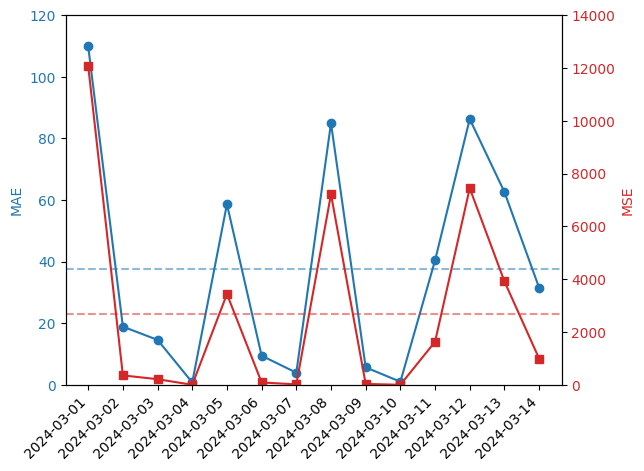


Average MAE: 37.75608934674944
Average MSE: 2673.616222557568

Day: 2024-03-01
Predicted Occupancy: [1757.6311]
True Occupancy: 1854.0

Day: 2024-03-02
Predicted Occupancy: [16.590757]
True Occupancy: 22.0

Day: 2024-03-03
Predicted Occupancy: [8.939788]
True Occupancy: 21.0

Day: 2024-03-04
Predicted Occupancy: [1986.3241]
True Occupancy: 1978.0

Day: 2024-03-05
Predicted Occupancy: [1984.9615]
True Occupancy: 1991.0

Day: 2024-03-06
Predicted Occupancy: [1979.7533]
True Occupancy: 1962.0

Day: 2024-03-07
Predicted Occupancy: [1933.8348]
True Occupancy: 1963.0

Day: 2024-03-08
Predicted Occupancy: [1782.0798]
True Occupancy: 1709.0

Day: 2024-03-09
Predicted Occupancy: [18.577915]
True Occupancy: 22.0

Day: 2024-03-10
Predicted Occupancy: [13.557052]
True Occupancy: 14.0

Day: 2024-03-11
Predicted Occupancy: [2018.8649]
True Occupancy: 2030.0

Day: 2024-03-12
Predicted Occupancy: [2106.4863]
True Occupancy: 2010.0

Day: 2024-03-13
Predicted Occupancy: [1985.7692]
True Occupancy: 1927

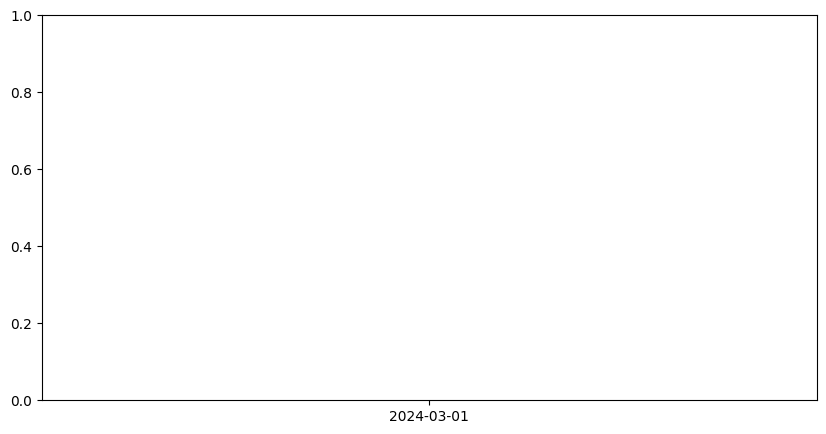

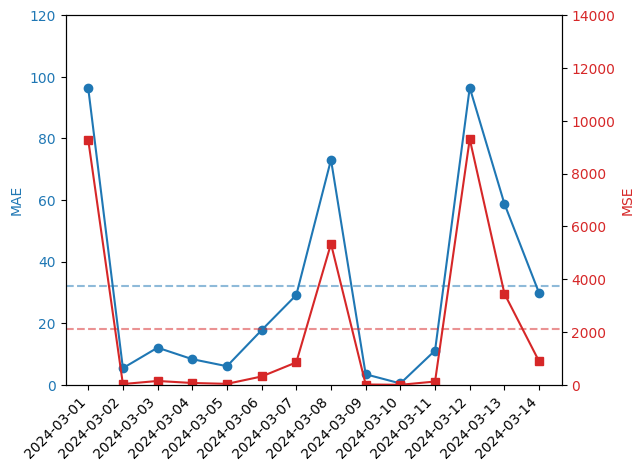


Average MAE: 32.01668112618582
Average MSE: 2132.8549336134615

Day: 2024-03-01
Predicted Occupancy: [1846.4314]
True Occupancy: 1960.0

Day: 2024-03-02
Predicted Occupancy: [28.833439]
True Occupancy: 34.0

Day: 2024-03-03
Predicted Occupancy: [20.868027]
True Occupancy: 30.0

Day: 2024-03-04
Predicted Occupancy: [2122.2725]
True Occupancy: 2102.0

Day: 2024-03-05
Predicted Occupancy: [2129.5142]
True Occupancy: 2149.0

Day: 2024-03-06
Predicted Occupancy: [2124.9768]
True Occupancy: 2113.0

Day: 2024-03-07
Predicted Occupancy: [2062.3418]
True Occupancy: 2104.0

Day: 2024-03-08
Predicted Occupancy: [1876.4009]
True Occupancy: 1818.0

Day: 2024-03-09
Predicted Occupancy: [25.718246]
True Occupancy: 33.0

Day: 2024-03-10
Predicted Occupancy: [23.004776]
True Occupancy: 25.0

Day: 2024-03-11
Predicted Occupancy: [2148.5955]
True Occupancy: 2154.0

Day: 2024-03-12
Predicted Occupancy: [2278.5054]
True Occupancy: 2163.0

Day: 2024-03-13
Predicted Occupancy: [2135.8896]
True Occupancy: 20

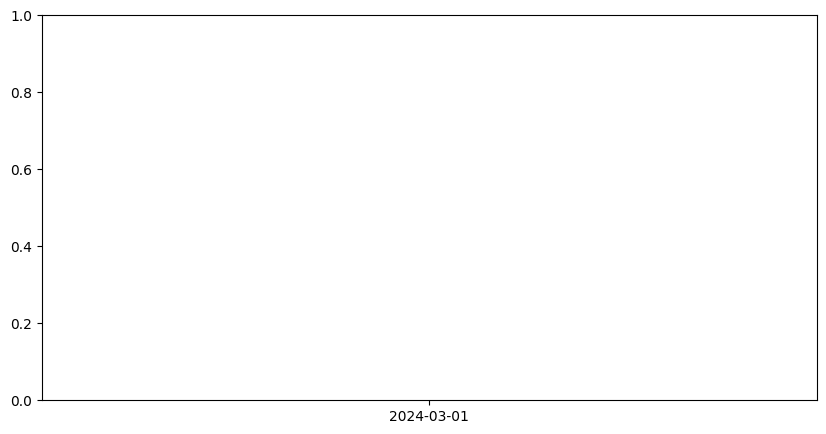

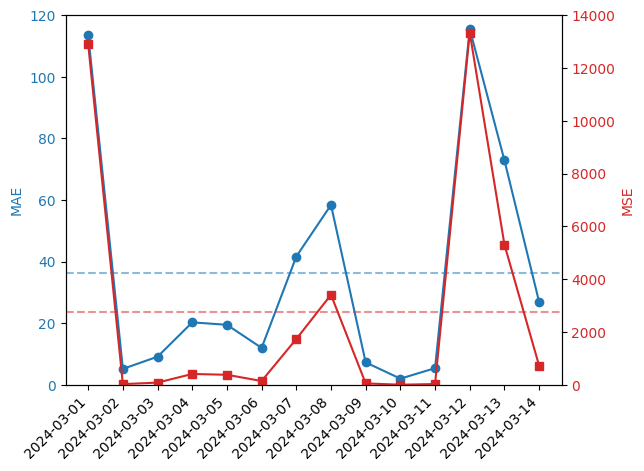


Average MAE: 36.406202861240935
Average MSE: 2753.924986662627

Day: 2024-03-01
Predicted Occupancy: [21.536283]
True Occupancy: 0.0

Day: 2024-03-02
Predicted Occupancy: [4.4997215]
True Occupancy: 0.0

Day: 2024-03-03
Predicted Occupancy: [6.01328]
True Occupancy: 0.0

Day: 2024-03-04
Predicted Occupancy: [1731.5641]
True Occupancy: 1691.0

Day: 2024-03-05
Predicted Occupancy: [1678.8604]
True Occupancy: 1704.0

Day: 2024-03-06
Predicted Occupancy: [1603.862]
True Occupancy: 1639.0

Day: 2024-03-07
Predicted Occupancy: [1574.4733]
True Occupancy: 1661.0

Day: 2024-03-08
Predicted Occupancy: [-4.5553956]
True Occupancy: 0.0

Day: 2024-03-09
Predicted Occupancy: [-5.1696362]
True Occupancy: 0.0

Day: 2024-03-10
Predicted Occupancy: [0.02754705]
True Occupancy: 0.0

Day: 2024-03-11
Predicted Occupancy: [1735.4807]
True Occupancy: 1728.0

Day: 2024-03-12
Predicted Occupancy: [1752.81]
True Occupancy: 1686.0

Day: 2024-03-13
Predicted Occupancy: [1664.3446]
True Occupancy: 1648.0

Day: 2

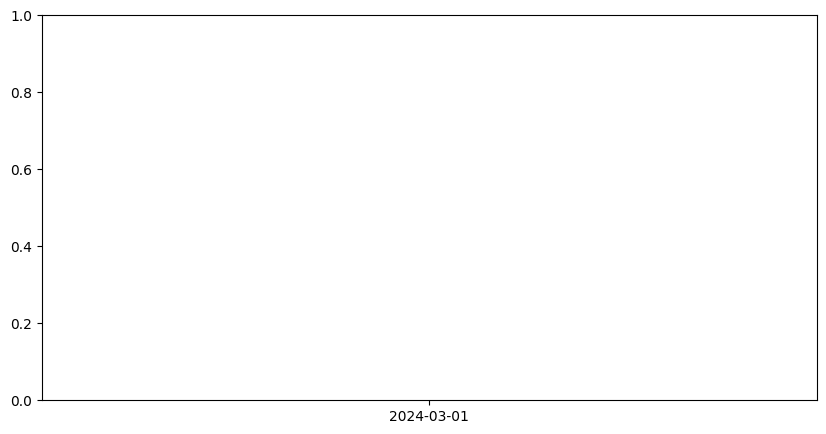

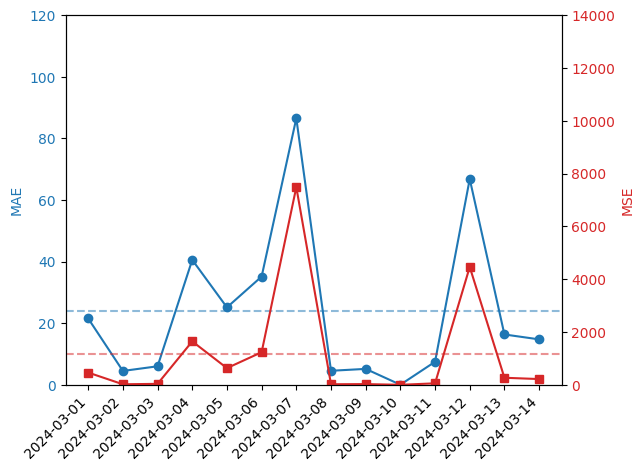


Average MAE: 23.897093580370502
Average MSE: 1183.6467965276315


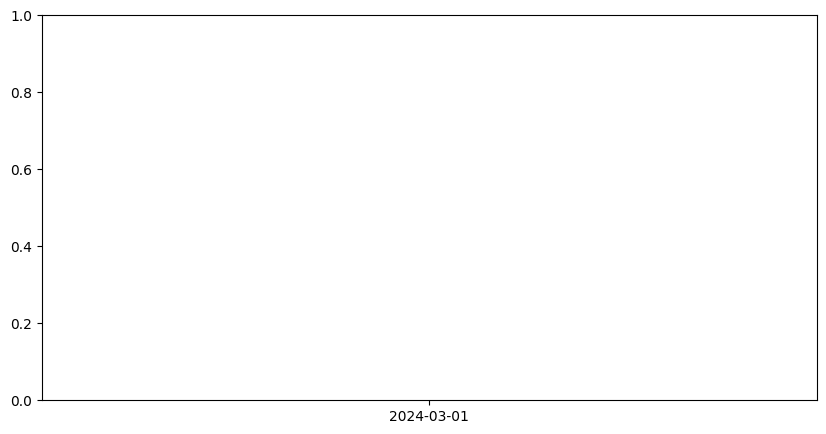

In [287]:
# PREDICT PAST AND FUTURE DATA (01/03 - 26/03)

df2 = final_df.copy()
df2.loc[df2['date'] > '2024-03-14', ['occupancy', 'occup_workplaces', 'exp_occup_restaurant', 'occup_restaurant']] = np.nan

total_occ_df = df2[['occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
predict_occupancy(total_occ_df, "2024-03-01", "2024-03-26")


workplace_occup_df2 = df2[['occup_workplaces', 'occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
workplace_occup_df2 = workplace_occup_df2.rename(columns={'occupancy': 'occupancy_total'})
# Add predicted total occupancy
workplace_occup_df2 = pd.merge(workplace_occup_df2, total_occ_df[['date', 'predicted_occupancy']], on='date', how='left')
workplace_occup_df2['occupancy_total'] = workplace_occup_df2.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['occupancy_total'], axis=1)
workplace_occup_df2 = workplace_occup_df2.drop(columns=['predicted_occupancy'])
workplace_occup_df2 = workplace_occup_df2.rename(columns={'occup_workplaces': 'occupancy'})
predict_occupancy(workplace_occup_df2, "2024-03-01", "2024-03-26")



exp_rest_occup_df2 = df2[['exp_occup_restaurant', 'occupancy', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
exp_rest_occup_df2 = exp_rest_occup_df2.rename(columns={'occupancy': 'occupancy_total'})
# Add predicted total occupancy
exp_rest_occup_df2 = pd.merge(exp_rest_occup_df2, total_occ_df[['date', 'predicted_occupancy']], on='date', how='left')
exp_rest_occup_df2['occupancy_total'] = exp_rest_occup_df2.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['occupancy_total'], axis=1)
exp_rest_occup_df2 = exp_rest_occup_df2.drop(columns=['predicted_occupancy'])
exp_rest_occup_df2 = exp_rest_occup_df2.rename(columns={'exp_occup_restaurant': 'occupancy'})
predict_occupancy(exp_rest_occup_df2, "2024-03-01", "2024-03-26")



# Predict restaurant occupancy with expected restaurant occupancy resulting from before
rest_occup_df3 = df2[['occup_restaurant', 'exp_occup_restaurant', 'date', 'reserv_workplace','capacity','year','month','day_month','day_week',
                         'day_type','weather_code','temperature_2m_max','temperature_2m_min','precipitation_sum']]
# Add predicted expected occupancy
rest_occup_df3 = pd.merge(rest_occup_df3, exp_rest_occup_df2[['date', 'predicted_occupancy']], on='date', how='left')
rest_occup_df3['exp_occup_restaurant'] = rest_occup_df3.apply(lambda row: row['predicted_occupancy'] if pd.notnull(row['predicted_occupancy']) else row['exp_occup_restaurant'], axis=1)
rest_occup_df3 = rest_occup_df3.drop(columns=['predicted_occupancy'])
rest_occup_df3 = rest_occup_df3.rename(columns={'occup_restaurant': 'occupancy'})
predict_occupancy(rest_occup_df3, "2024-03-01", "2024-03-26")

In [291]:
# STORE RESULTS

predictions_df = pd.merge(df2, total_occ_df[['date', 'predicted_occupancy']], on='date', how='left')
try:
    predictions_df['pred_total_occup'] = predictions_df.apply(lambda row: row['pred_total_occup'] if pd.notnull(row['pred_total_occup']) else row['predicted_occupancy'], axis=1)
    predictions_df = predictions_df.drop(columns=['predicted_occupancy'])
except:
    predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_total_occup'})


predictions_df = pd.merge(predictions_df, workplace_occup_df2[['date', 'predicted_occupancy']], on='date', how='left')
try:
    predictions_df['pred_workplace_occup'] = predictions_df.apply(lambda row: row['pred_workplace_occup'] if pd.notnull(row['pred_workplace_occup']) else row['predicted_occupancy'], axis=1)
    predictions_df = predictions_df.drop(columns=['predicted_occupancy'])
except:
    predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_workplace_occup'})


predictions_df = pd.merge(predictions_df, exp_rest_occup_df2[['date', 'predicted_occupancy']], on='date', how='left')
try:
    predictions_df['pred_exp_rest_occup'] = predictions_df.apply(lambda row: row['pred_exp_rest_occup'] if pd.notnull(row['pred_exp_rest_occup']) else row['predicted_occupancy'], axis=1)
    predictions_df = predictions_df.drop(columns=['predicted_occupancy'])
except:
    predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_exp_rest_occup'})
    
predictions_df = pd.merge(predictions_df, rest_occup_df3[['date', 'predicted_occupancy']], on='date', how='left')
try:
    predictions_df['pred_rest_occup'] = predictions_df.apply(lambda row: row['pred_rest_occup'] if pd.notnull(row['pred_rest_occup']) else row['predicted_occupancy'], axis=1)
    predictions_df = predictions_df.drop(columns=['predicted_occupancy'])
except:
    predictions_df = predictions_df.rename(columns={'predicted_occupancy': 'pred_rest_occup'})

predictions_df[predictions_df['date'] >= "2024-03-01"]

,date,capacity,reserv_workplace,occupancy,occup_workplaces,exp_occup_restaurant,occup_restaurant,day_month,month,year,day_week,day_type,weather_code,temperature_2m_max,temperature_2m_min,precipitation_sum,pred_total_occup,pred_workplace_occup,pred_exp_rest_occup,pred_rest_occup
568,2024-03-01,3571.0,2193.0,2313.0,1854.0,1960.0,0.0,1,3,2024,5,1,3.0,12.776000,-0.274,0.0,2203.101074,1757.631104,1846.431396,21.536283
569,2024-03-02,3571.0,0.0,68.0,22.0,34.0,0.0,2,3,2024,6,2,63.0,8.226000,0.426,6.4,49.114510,16.590757,28.833439,4.499722
570,2024-03-03,3571.0,0.0,56.0,21.0,30.0,0.0,3,3,2024,7,2,3.0,8.576000,0.276,0.0,41.414265,8.939788,20.868027,6.013280
571,2024-03-04,3571.0,2224.0,2601.0,1978.0,2102.0,1691.0,4,3,2024,1,1,3.0,12.726000,2.026,0.0,2601.770996,1986.324097,2122.272461,1731.564087
572,2024-03-05,3571.0,2231.0,2655.0,1991.0,2149.0,1704.0,5,3,2024,2,0,3.0,12.376000,1.576,0.0,2596.370117,1984.961548,2129.514160,1678.860352
573,2024-03-06,3571.0,2253.0,2591.0,1962.0,2113.0,1639.0,6,3,2024,3,0,3.0,13.376000,0.826,0.0,2581.552246,1979.753296,2124.976807,1603.862061
574,2024-03-07,3571.0,2264.0,2538.0,1963.0,2104.0,1661.0,7,3,2024,4,0,63.0,13.126000,2.476,9.4,2534.062256,1933.834839,2062.341797,1574.473267
575,2024-03-08,3571.0,2198.0,2163.0,1709.0,1818.0,0.0,8,3,2024,5,1,63.0,10.076000,3.876,9.0,2247.947754,1782.079834,1876.400879,-4.555396
576,2024-03-09,3571.0,0.0,51.0,22.0,33.0,0.0,9,3,2024,6,2,63.0,7.176000,2.726,14.9,56.673321,18.577915,25.718246,-5.169636
577,2024-03-10,3571.0,0.0,42.0,14.0,25.0,0.0,10,3,2024,7,2,53.0,11.776000,3.826,2.0,42.987579,13.557052,23.004776,0.027547
